In [245]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(sf)
    library(tidycensus)
    library(pbapply)
})
options(scipen = 999)

In [246]:
fires <- read_sf("~/data/wildfires/California_Fire_Perimeters-shp/California_Fire_Perimeters__all_.shp")
fires <- fires %>% 
    mutate(year = as.numeric(YEAR_)) %>%
    filter(year > 2006)
tracts <- readRDS("../data/projections/tract_final.rds") %>%
    filter(stateid == "06")

In [247]:
unique(tracts$year)
length(unique(tracts$tractid))

[1] 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019

[1] 7970

### Build tract sf object for California

In [248]:
ca <- get_decennial(
    geography = "tract",
    variables = "P011001",
    geometry = TRUE,
    state = "CA",
    cache = TRUE
)

Getting data from the 2010 decennial Census


Using Census Summary File 1



In [249]:
ca <- st_transform(ca, st_crs(fires))

In [250]:
# Plot settings
plot_theme <- 
  theme_bw() +
  theme(axis.text = element_text(size = 20),
        axis.title = element_text(size = 23, face = "bold"),
        axis.title.x = element_text(margin = margin(t = 20)),
        axis.title.y = element_text(margin = margin(r = 20)),
        plot.title = element_text(size = 27, face = "bold", hjust = 0.5),
        legend.position = "none")

In [251]:
cali_border <- st_union(ca$geometry)

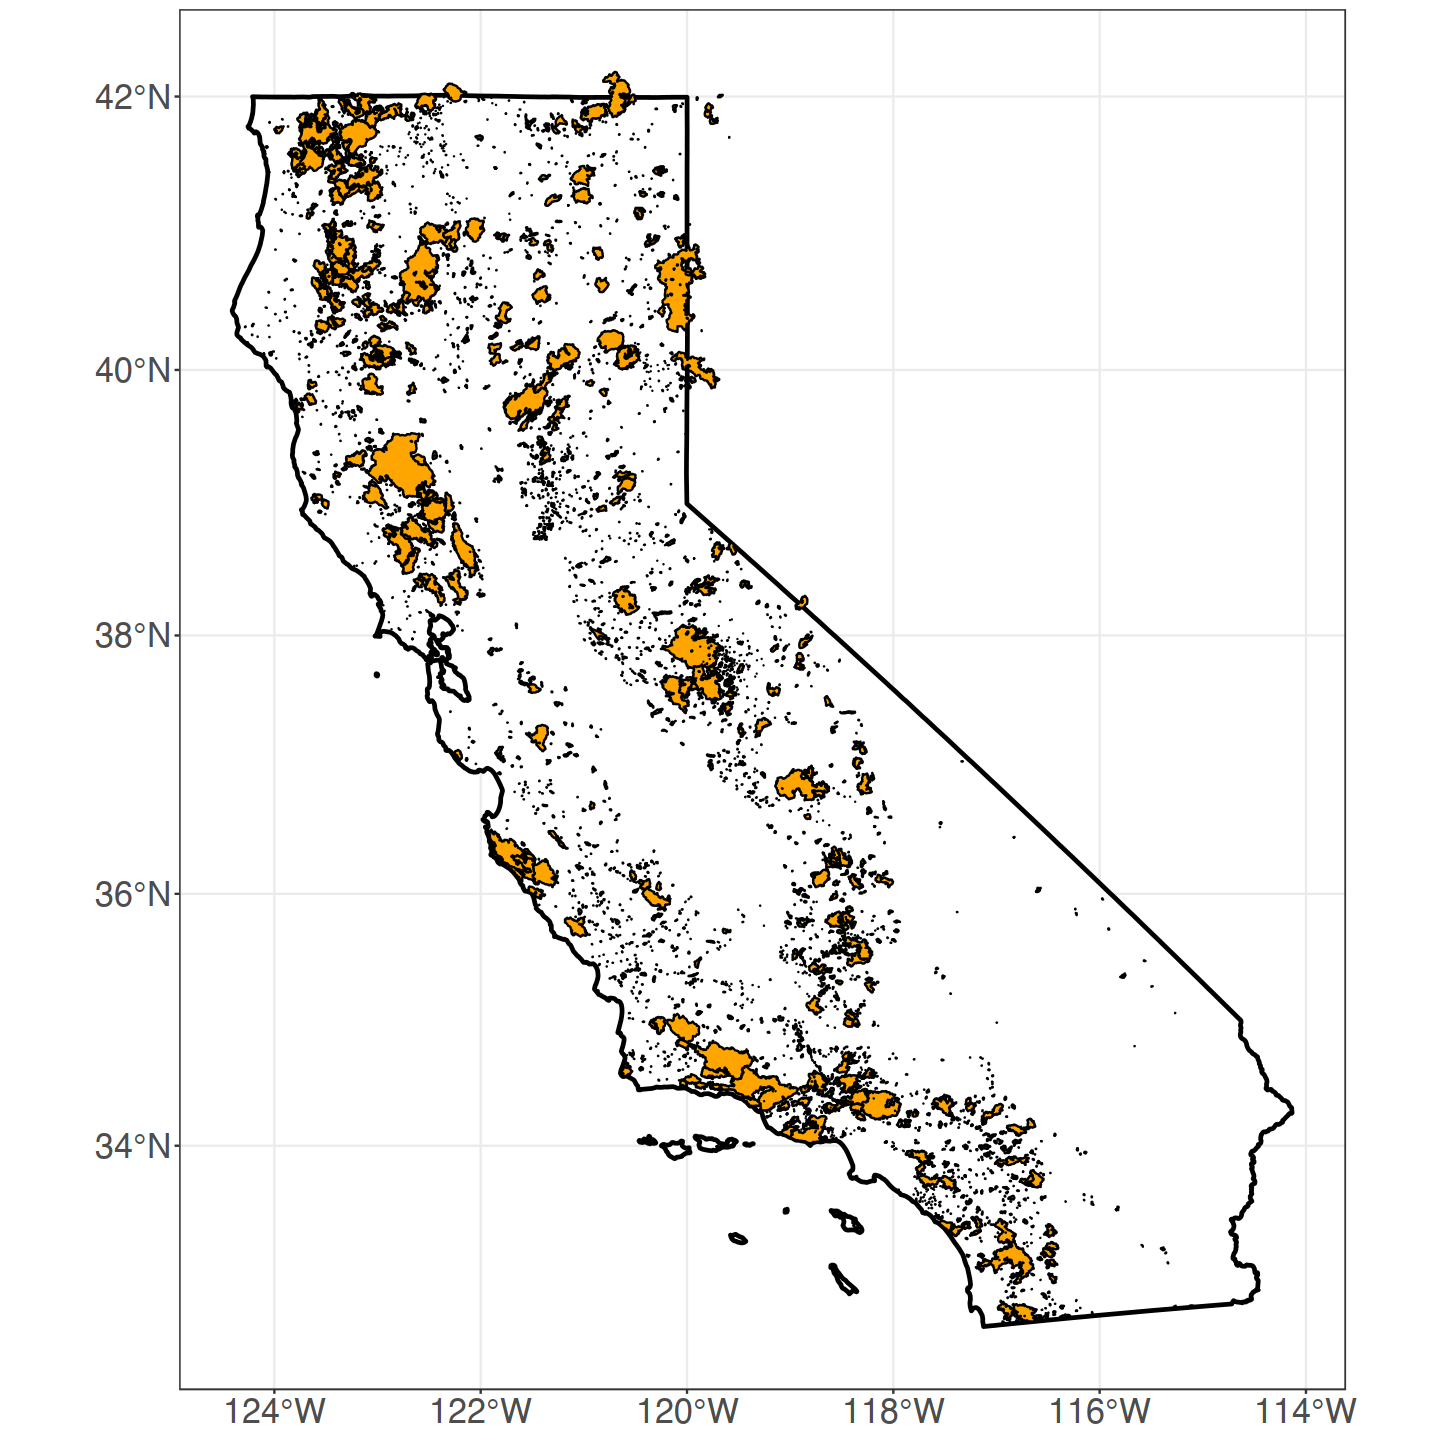

In [252]:
options(repr.plot.width=12, repr.plot.height=12)

ggplot() +
    geom_sf(data = cali_border, fill = 'white', color = 'black', size = 1) +
    geom_sf(data = fires, fill = 'orange', color = "black") +
    plot_theme

In [253]:
tracts <- ca %>%
    select(GEOID) %>%
    rename('tractid' = GEOID) %>%
    right_join(tracts)

Joining, by = "tractid"



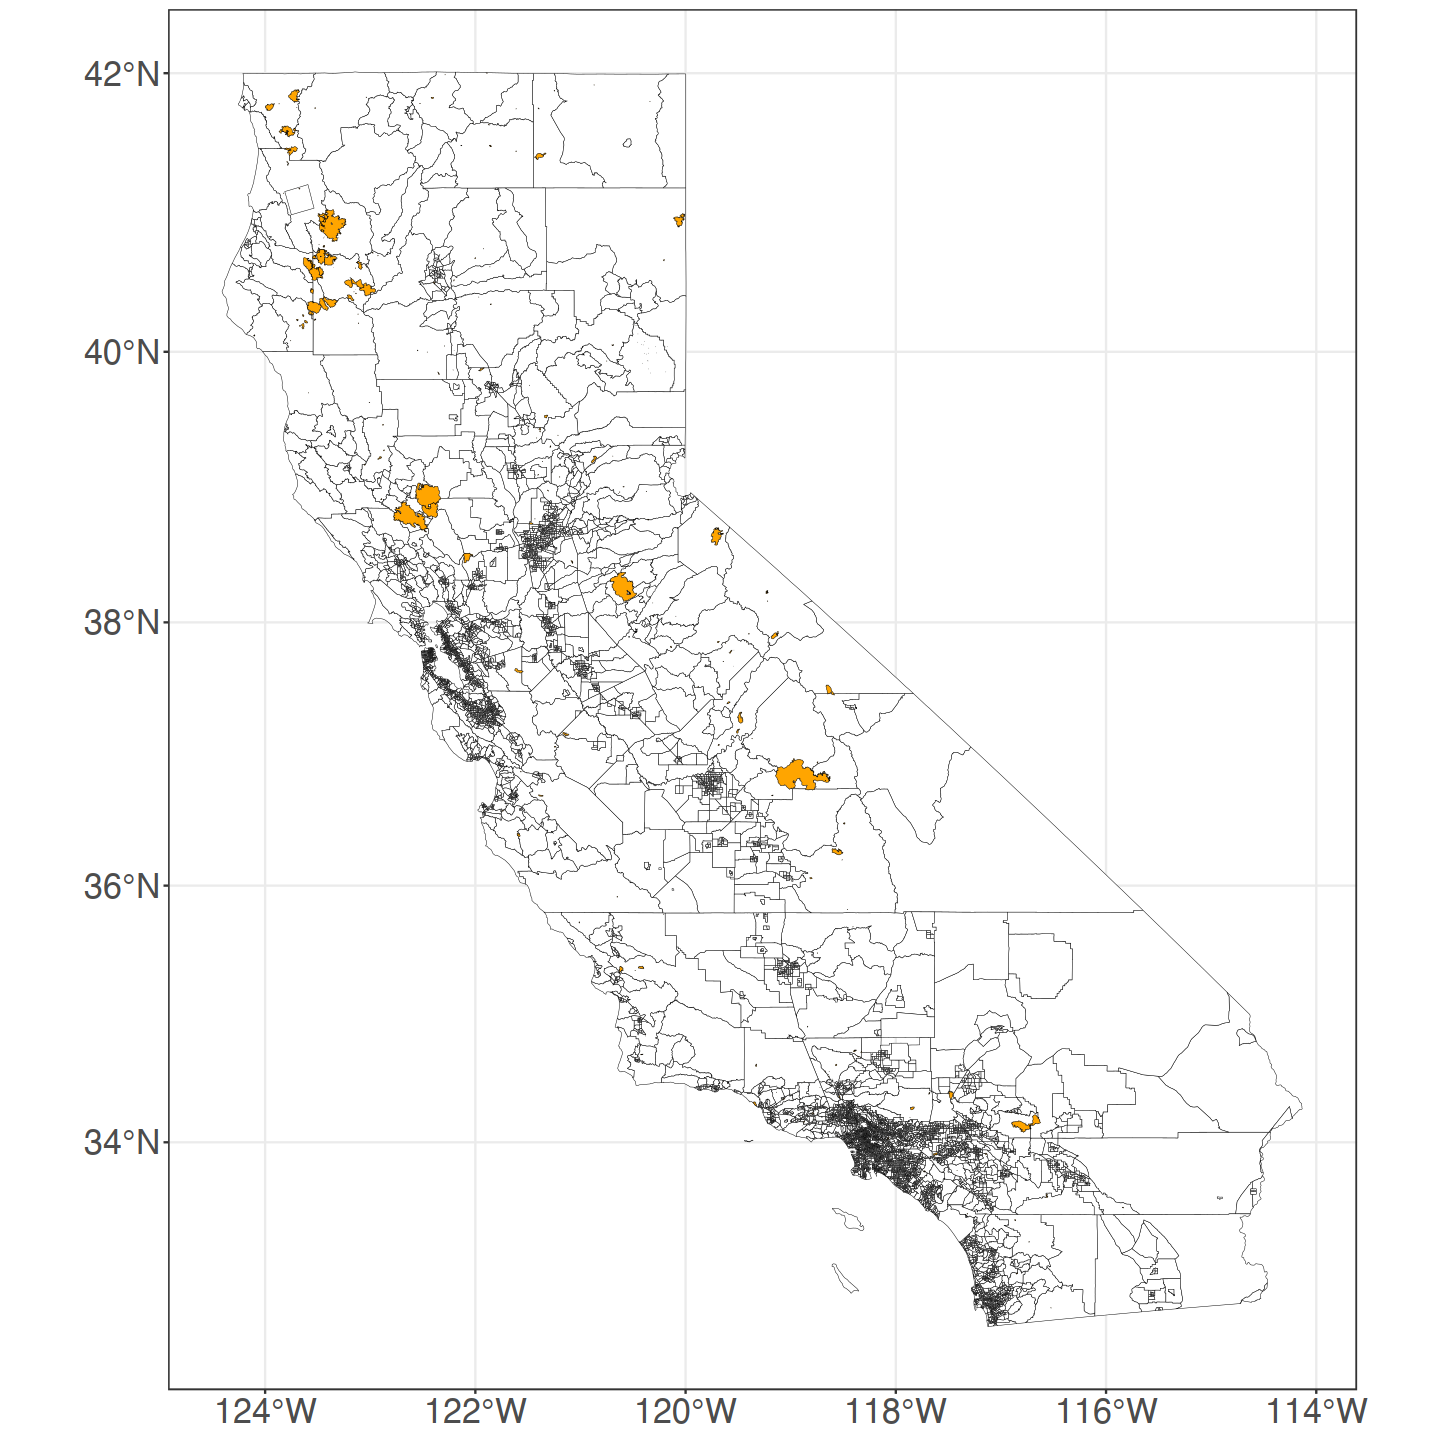

In [268]:
tracts_2015 <- tracts %>% filter(year == 2015)
fires_2015 <- fires %>% filter(year == 2015)

ggplot() +
    geom_sf(data = tracts_2015, fill = 'white', color = "black", size = .1) +
    geom_sf(data = fires_2015, fill = 'orange', color = "black", size = .1) +
    plot_theme

In [259]:
head(tracts_2006)

tractid     geometry                       year ig_count_imptd chh chh_moe
1 06001425103 MULTIPOLYGON (((-13613523 4... 2006  911           NA  NA     
2 06001425104 MULTIPOLYGON (((-13611991 4... 2006  907           NA  NA     
3 06001426100 MULTIPOLYGON (((-13606368 4... 2006 1840           NA  NA     
4 06001427100 MULTIPOLYGON (((-13606574 4... 2006 1120           NA  NA     
5 06001427800 MULTIPOLYGON (((-13610314 4... 2006 1340           NA  NA     
6 06001428302 MULTIPOLYGON (((-13609039 4... 2006 2163           NA  NA     
  ig_count lead lag  geoid      ⋯ ruca_1 ruca_2 area_sqmi chh_density lprd_1  
1 1104     1247 1110 6001000000 ⋯ 1      1      0.3405204 3747.206    7.207639
2  987     1211  969 6001000000 ⋯ 1      1      0.4154191 3945.413    7.138252
3 2042     2139 1905 6001000000 ⋯ 1      1      1.1548920 1832.206    7.626325
4 1208     1270 1128 6001000000 ⋯ 1      1      0.3959279 3513.266    7.202711
5 1359     1520 1315 6001000000 ⋯ 1      1      0.3209091 6207.366    7.546087
6 2360     2447 2210 6001000000 ⋯ 1      1      0.8634067 3081.977    7.845741
  lu90_1   ll90_1   prd_1    u90_1    l90_1   
1 7.222895 7.191925 1349.702 1370.451 1328.658
2 7.153279 7.122570 1259.226 1278.291 1239.632
3 7.648315 7.603805 2051.497 2097.110 2005.813
4 7.217859 7.187772 1343.067 1363.567 1323.152
5 7.562669 7.529433 1893.319 1924.977 1862.050
6 7.871165 7.819819 2554.831 2620.616 2489.454

In [229]:
fires_in_tract <- st_intersects(
    ca,
    fires
)

In [230]:
ca$years_affected <- sapply(fires_in_tract, function(x) {
    if (length(x) > 0) {
        unique(sapply(x, function(y) return(fires$year[y])))
    } else {
        return(0)
    }
})

In [232]:
ca$fire <- sapply(ca$years_affected, function(x) ifelse(x[[1]] == 0, FALSE, TRUE))
table(ca$fire)


FALSE  TRUE 
 7078   979 

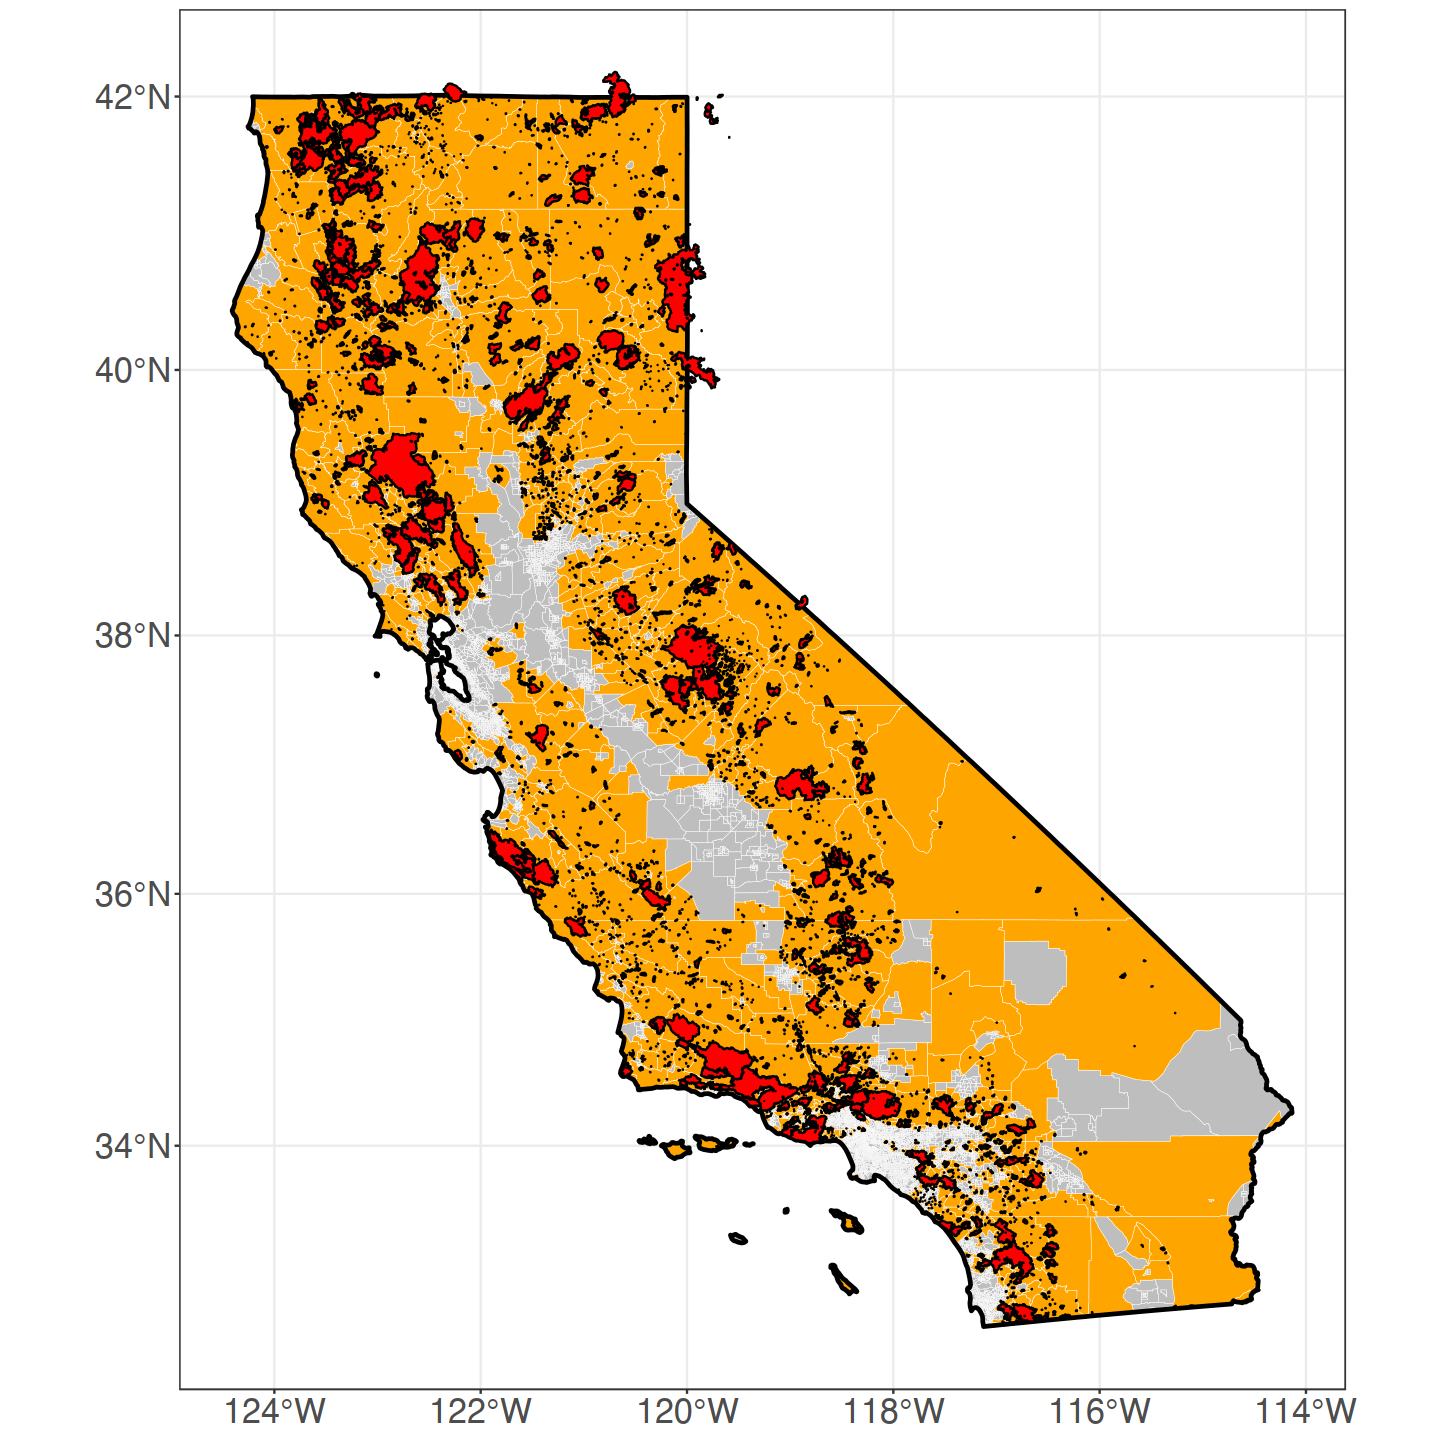

In [233]:
options(repr.plot.width=12, repr.plot.height=12)

ggplot() +
    geom_sf(data = ca, aes(fill = fire), color = 'white', size = .1) +
    scale_fill_manual(values = c("grey", "orange")) +
    geom_sf(data = cali_border, fill = NA, color = 'black', size = 1) +
    geom_sf(data = fires, fill = 'red', color = "black") +
    plot_theme

In [234]:
fire <- c()
for(ii in seq_len(nrow(tracts))) {
    id <- tracts$tractid[ii]
    year <- tracts$year[ii]
    
    tract <- ca %>% filter(GEOID == id)
    if (year %in% tract$years_affected) {
        fire <- c(fire, TRUE)
    } else {
        fire <- c(fire, FALSE)
    }
}
tracts$fire <- fire

In [235]:
table(tracts$fire)
head(tracts)


 FALSE   TRUE 
111179    394 

tractid,year,ig_count_imptd,chh,chh_moe,ig_count,lead,lag,geoid,pown,⋯,ruca_2,area_sqmi,chh_density,lprd_1,lu90_1,ll90_1,prd_1,u90_1,l90_1,fire
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
06001400100,2006,1008,NA,NA,1122,1176,1026,6001000000,0.8508371,⋯,1,2.6572480,494.4965,7.117980,7.132855,7.102946,1233.9559,1252.4477,1215.5431,FALSE
06001400200,2006,648,NA,NA,688,735,643,6001000000,0.5934579,⋯,1,0.2297716,3725.4380,6.751010,6.770029,6.731605,854.9216,871.3376,838.4917,FALSE
06001400300,2006,1573,NA,NA,1661,1841,1557,6001000000,0.4288668,⋯,1,0.4267693,5665.8240,7.677820,7.697097,7.658618,2159.9069,2201.9466,2118.8282,FALSE
06001400400,2006,1160,NA,NA,1218,1356,1160,6001000000,0.4187746,⋯,1,0.2716953,6547.7750,7.402244,7.417659,7.386493,1639.6596,1665.1314,1614.0365,FALSE
06001400500,2006,965,NA,NA,979,1109,972,6001000000,0.3852978,⋯,1,0.2270708,6949.3730,7.247306,7.262403,7.231807,1404.3163,1425.6779,1382.7188,FALSE
06001400600,2006,438,NA,NA,445,505,432,6001000000,0.3884058,⋯,1,0.1150024,5999.8750,6.498741,6.526192,6.471343,664.3045,682.7932,646.3510,FALSE


In [241]:
tracts <- ca %>%
    select(GEOID) %>%
    rename('tractid' = GEOID) %>%
    right_join(tracts)

Joining, by = "tractid"



ERROR while rich displaying an object: Error: stat_sf requires the following missing aesthetics: geometry

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(o

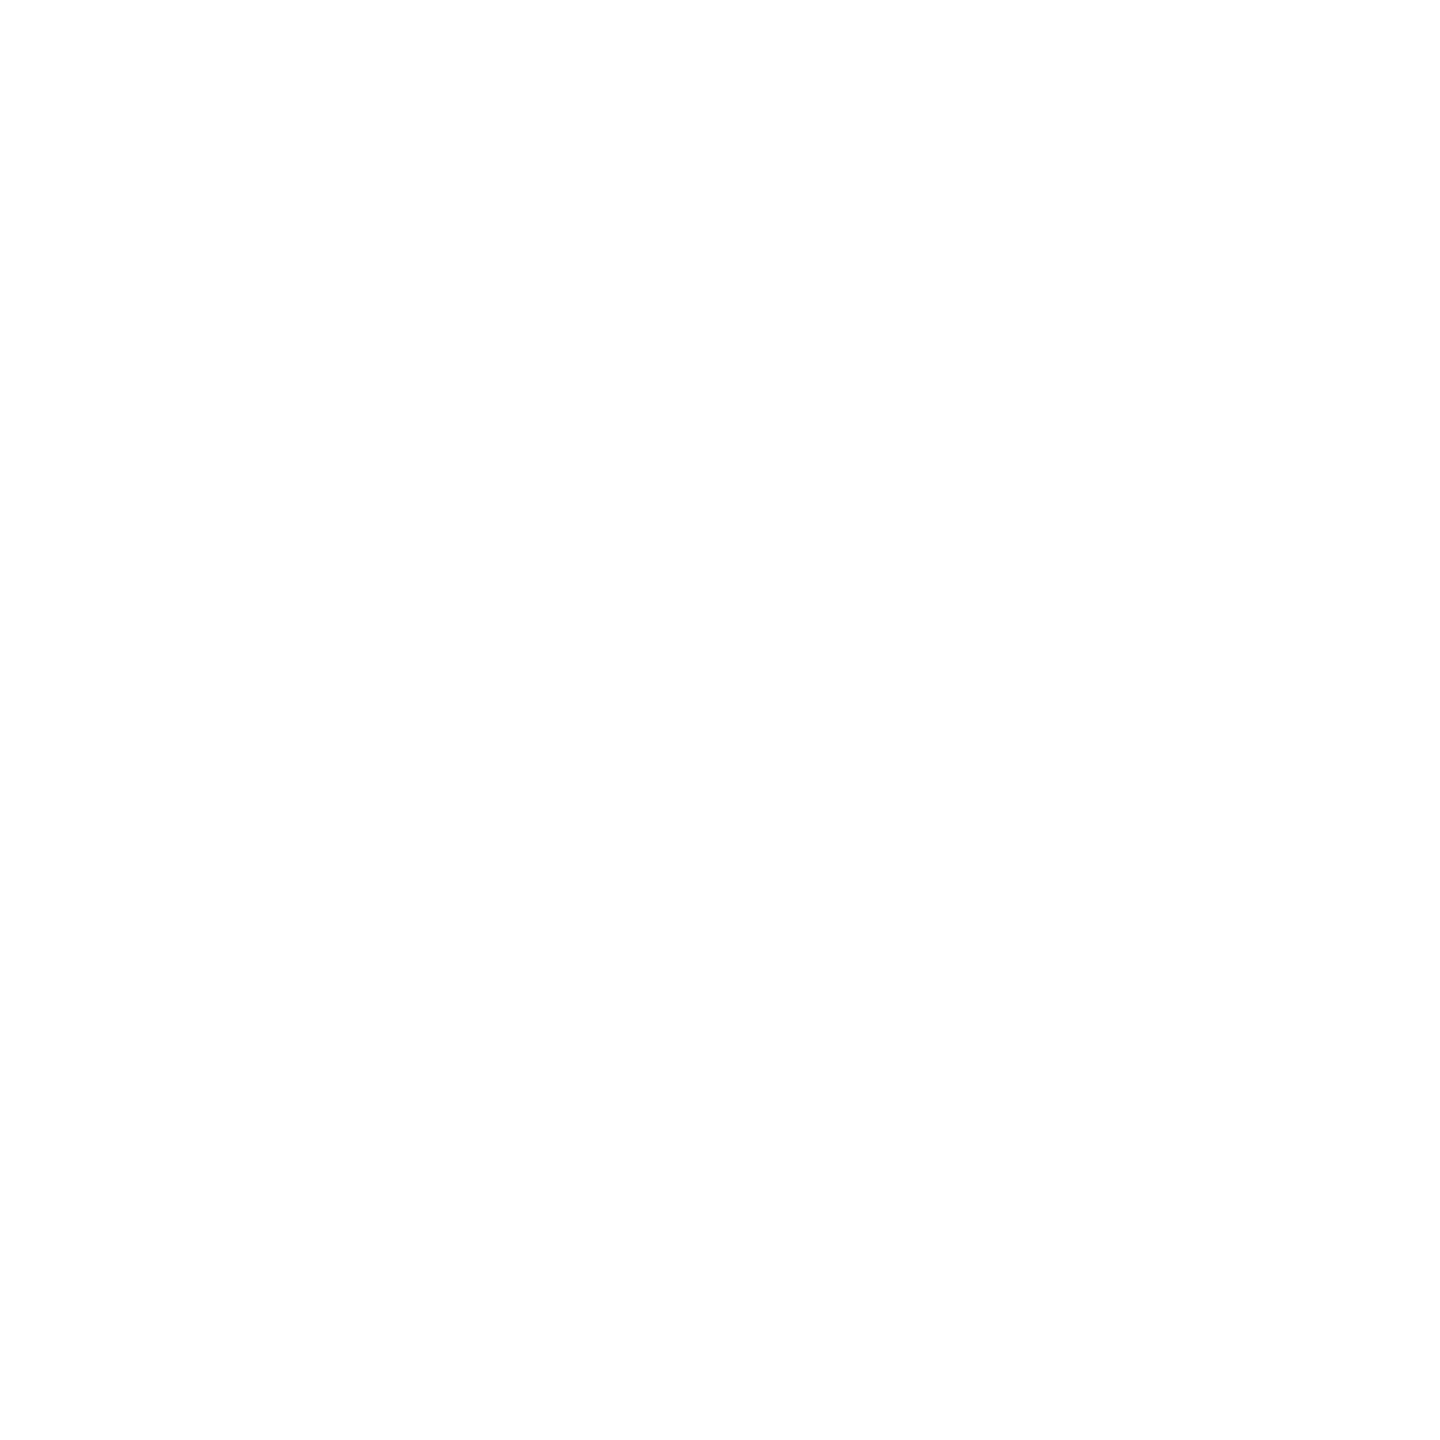

In [236]:
options(repr.plot.width=12, repr.plot.height=12)

ggplot() +
    geom_sf(data = tracts, aes(fill = fire), color = 'white', size = .1) +
    scale_fill_manual(values = c("grey", "orange")) +
    geom_sf(data = cali_border, fill = NA, color = 'black', size = 1) +
    geom_sf(data = fires, fill = 'red', color = "black") +
    facet_grid(. ~ year)
    plot_theme